<a href="https://colab.research.google.com/github/serahgkurian/Exemplar-based-colorization/blob/main/imagecolorization_exemplarebased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install necessary packages
!pip install -q fastdownload tqdm

# Step 2: Import libraries
import os
import torch
import torchvision.transforms as T
from torchvision.models import vgg19
from torchvision.datasets import ImageFolder
from fastdownload import FastDownload
from PIL import Image
from tqdm import tqdm
import numpy as np
from torch.nn.functional import normalize

# Step 3: Download ImageNette dataset (160px version)
fd = FastDownload()
path = fd.get('https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz')
base_dir = path.parent/'imagenette2-160'
train_dir = base_dir/'train'
val_dir = base_dir/'val'

In [ ]:
# Preprocessing transform for VGG (224x224 RGB, normalized)
vgg_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load validation set by class
val_dataset = ImageFolder(root=val_dir, transform=vgg_transform)
class_to_idx = val_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}


In [ ]:
# Load pretrained VGG19 and extract features from 'conv4_2'
vgg = vgg19(pretrained=True).features.eval().cuda()
for param in vgg.parameters():
    param.requires_grad = False

# Truncate VGG at conv4_2 (layer index 21)
vgg_trunc = torch.nn.Sequential(*list(vgg.children())[:22])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 110MB/s] 


In [ ]:
def extract_vgg_features(img_tensor):
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).cuda()
        features = vgg_trunc(img_tensor)  # shape: [1, 512, 28, 28]
        pooled = torch.mean(features, dim=(2, 3))  # Global average pool -> [1, 512]
        return normalize(pooled, dim=1).squeeze(0).cpu()  # Normalize + remove batch


In [ ]:
def find_best_reference(target_index):
    target_img, target_class = val_dataset[target_index]
    target_class_idx = val_dataset.targets[target_index]

    # Extract target VGG features (grayscale expanded to 3 channels)
    target_img_rgb = target_img.clone()
    target_features = extract_vgg_features(target_img_rgb)

    best_score = -1
    best_idx = -1

    # Search within the same class only
    for idx in tqdm(range(len(val_dataset)), desc="Searching reference"):
        if idx == target_index:
            continue
        img, label = val_dataset[idx]
        if label != target_class_idx:
            continue

        ref_features = extract_vgg_features(img)
        score = torch.dot(target_features, ref_features).item()  # Cosine similarity

        if score > best_score:
            best_score = score
            best_idx = idx

    return target_index, best_idx, val_dataset[target_index], val_dataset[best_idx]


Searching reference: 100%|██████████| 3925/3925 [00:18<00:00, 212.37it/s]


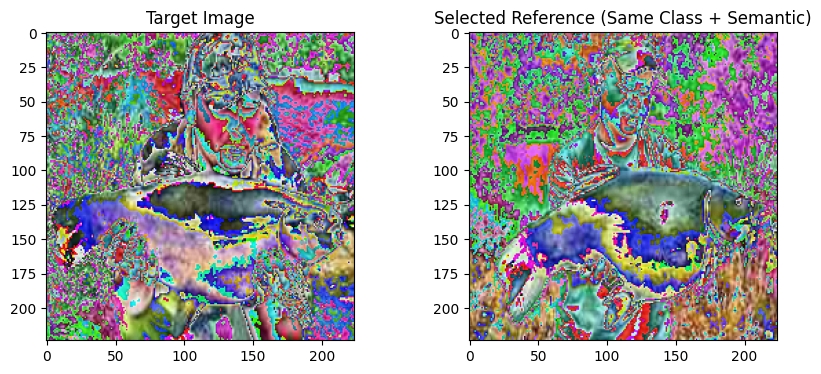

In [ ]:
# Example: Pick a target image index from validation set
target_idx = 42  # pick any index (0–len(val_dataset)-1)

t_idx, r_idx, (target_img, _), (ref_img, _) = find_best_reference(target_idx)

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(T.ToPILImage()(target_img.cpu()))
plt.title("Target Image")

plt.subplot(1, 2, 2)
plt.imshow(T.ToPILImage()(ref_img.cpu()))
plt.title("Selected Reference (Same Class + Semantic)")

plt.show()


In [ ]:
from skimage.color import rgb2lab
from torchvision.transforms.functional import to_pil_image
import numpy as np
import torch

# Define unnormalization transform
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

def unnormalize_img(tensor):
    # tensor shape [B, 3, H, W] or [3, H, W]
    if tensor.ndim == 3:
        tensor = tensor.unsqueeze(0) # Add batch dim if missing
    unnormalized = tensor * imagenet_std.to(tensor.device) + imagenet_mean.to(tensor.device)
    return unnormalized.squeeze(0) # Remove batch dim if added

def rgb_tensor_to_lab(tensor):
    # Convert torch.Tensor [3, H, W] → unnormalize → numpy RGB → LAB
    # Ensure tensor is on CPU and unnormalized
    tensor = unnormalize_img(tensor.cpu()) # [3, H, W]

    # Scale to [0, 255], permute, and create a contiguous uint8 numpy array
    image_np = (tensor.permute(1, 2, 0).contiguous().numpy() * 255).astype(np.uint8) # [H, W, 3] uint8

    lab = rgb2lab(image_np)  # shape (H, W, 3)
    lab = lab.transpose(2, 0, 1)    # → (3, H, W)
    return lab

In [ ]:
def extract_vgg_conv_features(img_tensor):
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).cuda()
        features = vgg_trunc(img_tensor)  # [1, 512, H', W']
        return features.squeeze(0).cpu()  # → [512, H', W']


In [ ]:
import torch.nn.functional as F

def warp_reference_ab(f_T, f_R, ref_ab, mode='nearest'):
    """
    Inputs:
    - f_T: [512, H, W] target features
    - f_R: [512, H, W] reference features
    - ref_ab: [2, H_orig, W_orig] from reference LAB

    Returns:
    - warped_ab: [2, H, W] chrominance channels warped using φT→R
    """

    C, H_feat, W_feat = f_T.shape # Use different variable names to avoid confusion
    f_T_flat = f_T.view(C, -1).T  # [H_feat*W_feat, 512]
    f_R_flat = f_R.view(C, -1).T  # [H_feat*W_feat, 512]

    # Normalize features for cosine similarity
    f_T_flat = F.normalize(f_T_flat, dim=1)
    f_R_flat = F.normalize(f_R_flat, dim=1)

    # Compute cosine similarity: [H_feat*W_target, H_feat*W_reference]
    sim = torch.matmul(f_T_flat, f_R_flat.T)  # (H_feat*W_feat, H_feat*W_feat)

    # For each target pixel, find the most similar reference location
    max_idx = torch.argmax(sim, dim=1)  # (H_feat*W_feat,)

    # Map index back to (h, w) coords in feature map size
    h_r_feat, w_r_feat = f_R.shape[1:]
    coords_y = (max_idx // w_r_feat).view(H_feat, W_feat)
    coords_x = (max_idx % w_r_feat).view(H_feat, W_feat)

    # Prepare ref_ab to be sampled (resize to match feature map size)
    ref_ab = torch.tensor(ref_ab, dtype=torch.float32)  # [2, H_orig, W_orig]
    # Resize ref_ab to match the feature map size (H_feat, W_feat)
    ref_ab = F.interpolate(ref_ab.unsqueeze(0), size=(int(H_feat), int(W_feat)), mode='bilinear', align_corners=False).squeeze(0)


    # Warp ab using selected reference locations
    warped_ab = torch.zeros_like(ref_ab) # Initialize with shape [2, H_feat, W_feat]

    for i in range(H_feat):
        for j in range(W_feat):
            y, x = coords_y[i, j], coords_x[i, j]
            warped_ab[:, i, j] = ref_ab[:, y, x] # Sample from resized ref_ab


    return warped_ab  # shape: [2, H_feat, W_feat]

In [ ]:
# Extract LAB versions
target_lab = rgb_tensor_to_lab(target_img)
ref_lab = rgb_tensor_to_lab(ref_img)

# Extract ab from reference
ref_ab = ref_lab[1:]  # [2, H, W]

# Extract deep features
target_feat = extract_vgg_conv_features(vgg_transform(to_pil_image(target_img)).cuda())
ref_feat = extract_vgg_conv_features(vgg_transform(to_pil_image(ref_img)).cuda())

# Warp
warped_ab = warp_reference_ab(target_feat, ref_feat, ref_ab)


<ipython-input-11-2334251874>:11: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab.astype(np.float32))


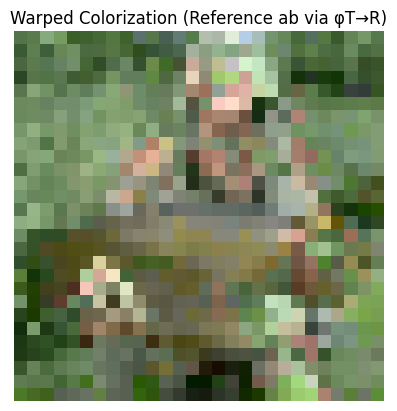

In [ ]:
from skimage.color import lab2rgb

def reconstruct_rgb_from_lab(L, ab):
    """
    L: [1, H, W]
    ab: [2, H, W]
    Returns RGB image [H, W, 3]
    """
    lab = np.concatenate([L, ab], axis=0)
    lab = lab.transpose(1, 2, 0)  # [H, W, 3]
    rgb = lab2rgb(lab.astype(np.float32))
    return rgb

# Resize target L to match ab shape
target_L = target_lab[0:1]  # [1, H, W]
target_L = F.interpolate(torch.tensor(target_L).unsqueeze(0), size=warped_ab.shape[1:], mode='bilinear', align_corners=False).squeeze(0).numpy()

# Warp ab → numpy
warped_ab_np = warped_ab.numpy()

# Reconstruct
reconstructed_rgb = reconstruct_rgb_from_lab(target_L, warped_ab_np)

# Plot
plt.imshow(reconstructed_rgb)
plt.title("Warped Colorization (Reference ab via φT→R)")
plt.axis('off')
plt.show()


In [ ]:
import torch.nn as nn
import torchvision.models as models

class VGGFeatureExtractor(nn.Module):
    def __init__(self, layers):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features.cuda() # Move VGG features to GPU here
        self.selected_layers = layers
        self.slices = []
        prev = 0
        for idx in self.selected_layers:
            self.slices.append(nn.Sequential(*vgg[prev:idx]))
            prev = idx
        for s in self.slices:
            for p in s.parameters():
                p.requires_grad = False

    def forward(self, x):
        features = []
        for s in self.slices:
            x = s(x)
            features.append(x)
        return features  # list of feature maps

In [ ]:
vgg_layers = [4, 9, 16, 23, 30]  # conv1_2 to conv5_3
vgg_multi = VGGFeatureExtractor(vgg_layers).cuda().eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn.functional as F

def compute_similarity_maps(img_T, img_R, vgg_model):
    """
    Inputs:
    - img_T, img_R: [3, H, W] RGB tensors
    - vgg_model: multi-layer VGG extractor

    Output:
    - sim_maps: [10, H, W] tensor (5 from T→R, 5 from R→T)
    """

    # Prepare input
    T = vgg_transform(to_pil_image(img_T)).unsqueeze(0).cuda()
    R = vgg_transform(to_pil_image(img_R)).unsqueeze(0).cuda()

    # Ensure model is on the correct device
    vgg_model = vgg_model.cuda()


    # Extract multi-layer features
    T_feats = vgg_model(T)
    R_feats = vgg_model(R)

    sim_maps = []
    # Get the target size from the first layer's similarity map
    target_size = None

    for i, (fT, fR) in enumerate(zip(T_feats, R_feats)):  # loop over 5 layers
        B, C, H, W = fT.shape
        fT = F.normalize(fT.view(C, -1), dim=0)  # [C, H*W]
        fR = F.normalize(fR.view(C, -1), dim=0)  # [C, H*W]

        sim_T_to_R = torch.matmul(fT.T, fR)  # [H*W_T, H*W_R]
        max_sim_T = sim_T_to_R.max(dim=1)[0]  # [H*W_T]
        sim_map_T = max_sim_T.view(H, W)

        sim_R_to_T = sim_T_to_R.max(dim=0)[0]  # [H*W_R]
        sim_map_R = sim_R_to_T.view(H, W)

        if i == 0:
            target_size = sim_map_T.shape

        # Resize similarity maps to the target size
        sim_maps.append(F.interpolate(sim_map_T.unsqueeze(0).unsqueeze(0), size=target_size, mode='bilinear', align_corners=False).squeeze(0).squeeze(0))
        sim_maps.append(F.interpolate(sim_map_R.unsqueeze(0).unsqueeze(0), size=target_size, mode='bilinear', align_corners=False).squeeze(0).squeeze(0))


    sim_tensor = torch.stack(sim_maps)  # [10, H, W]
    return sim_tensor.cpu()

In [ ]:
sim_maps = compute_similarity_maps(target_img, ref_img, vgg_multi)
print("Similarity maps shape:", sim_maps.shape)  # should be [10, H, W]


Similarity maps shape: torch.Size([10, 224, 224])


In [ ]:
# target_L: [1, H, W] → normalize to [-1, 1]
target_L_tensor = torch.tensor(target_L / 50. - 1.0).float()  # [1, H_orig, W_orig]
# Resize target_L_tensor to match sim_maps size
target_L_tensor = F.interpolate(target_L_tensor.unsqueeze(0), size=sim_maps.shape[1:], mode='bilinear', align_corners=False).squeeze(0)

# warped_ab: [2, H, W] → normalize to [-1, 1]
warped_ab_tensor = torch.tensor(warped_ab_np / 110.).float()
# Resize warped_ab_tensor to match sim_maps size
warped_ab_tensor = F.interpolate(warped_ab_tensor.unsqueeze(0), size=sim_maps.shape[1:], mode='bilinear', align_corners=False).squeeze(0)


# Final input: [13, H, W]
final_input = torch.cat([target_L_tensor, warped_ab_tensor, sim_maps], dim=0)
print("Final input shape to network:", final_input.shape)  # [13, H, W]

Final input shape to network: torch.Size([13, 224, 224])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ColorizationUNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv(in_c, out_c, ks=3, stride=1, pad=1, bn=True):
            layers = [nn.Conv2d(in_c, out_c, ks, stride, pad)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        # Encoder
        self.enc1 = conv(13, 64)         # [B, 64, H, W]
        self.enc2 = conv(64, 128, stride=2)  # [B, 128, H/2, W/2]
        self.enc3 = conv(128, 256, stride=2) # [B, 256, H/4, W/4]
        self.enc4 = conv(256, 512, stride=2) # [B, 512, H/8, W/8]

        # Bottleneck
        self.middle = conv(512, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.dec3 = conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec2 = conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec1 = conv(128, 64)

        # Final prediction
        self.out_conv = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)       # [B, 64, H, W]
        e2 = self.enc2(e1)      # [B, 128, H/2, W/2]
        e3 = self.enc3(e2)      # [B, 256, H/4, W/4]
        e4 = self.enc4(e3)      # [B, 512, H/8, W/8]

        # Middle
        m = self.middle(e4)

        # Decoder
        d3 = self.up3(m)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        out_ab = torch.tanh(self.out_conv(d1))  # [-1, 1] range
        return out_ab


In [ ]:
netC = ColorizationUNet().cuda()
print(sum(p.numel() for p in netC.parameters() if p.requires_grad), "trainable parameters")


8222210 trainable parameters


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer_name='dec1'):
        self.model = model
        self.target_layer = dict(model.named_modules())[target_layer_name]
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)

        # Backward pass
        if class_idx is None:
            class_idx = output.mean()  # Use mean for regression-like output
        else:
            class_idx = output[0, class_idx].sum()

        self.model.zero_grad()
        class_idx.backward(retain_graph=True)

        # Generate CAM
        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.relu(cam)

        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.squeeze().cpu().numpy()

In [ ]:
def visualize_gradcam(model, input_tensor, original_img=None):
    """Simple Grad-CAM visualization"""
    grad_cam = GradCAM(model, target_layer_name='dec1')

    # Generate CAM
    cam = grad_cam.generate_cam(input_tensor)

    # Resize CAM to match input size
    import cv2
    h, w = input_tensor.shape[2], input_tensor.shape[3]
    cam_resized = cv2.resize(cam, (w, h))

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    if original_img is not None:
        plt.imshow(original_img)
        plt.title("Original Image")
    else:
        plt.imshow(input_tensor[0, 0].detach().cpu().numpy(), cmap='gray')  # Added .detach()
        plt.title("Input L Channel")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cam_resized, cmap='jet', alpha=0.8)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    if original_img is not None:
        plt.imshow(original_img)
        plt.imshow(cam_resized, cmap='jet', alpha=0.4)
        plt.title("Overlay")
    else:
        plt.imshow(input_tensor[0, 0].detach().cpu().numpy(), cmap='gray')  # Added .detach()
        plt.imshow(cam_resized, cmap='jet', alpha=0.4)
        plt.title("L + CAM Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
input_tensor = final_input.unsqueeze(0).cuda()  # [1, 13, H, W]
pred_ab = netC(input_tensor)  # [1, 2, H, W]
print("Predicted ab shape:", pred_ab.shape)
#stopped here..

Predicted ab shape: torch.Size([1, 2, 224, 224])


In [ ]:
from torch.utils.data import Dataset
import os
import random

class ColorizationDataset(Dataset):
    def __init__(self, imagenette_dataset):
        """
        Wraps a torchvision ImageFolder dataset.
        For each target image, randomly picks a reference image from the same class.
        """
        self.samples = imagenette_dataset.samples
        self.transform = imagenette_dataset.transform
        self.class_to_imgs = self._group_by_class(self.samples)

    def _group_by_class(self, samples):
        class_to_imgs = {}
        for path, label in samples:
            if label not in class_to_imgs:
                class_to_imgs[label] = []
            class_to_imgs[label].append(path)
        return class_to_imgs

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        target_path, class_idx = self.samples[idx]
        # Load target image
        target_img = Image.open(target_path).convert("RGB")
        target_img_tensor = self.transform(target_img)

        # Random reference image from the same class
        ref_path = random.choice([p for p in self.class_to_imgs[class_idx] if p != target_path])
        ref_img = Image.open(ref_path).convert("RGB")
        ref_img_tensor = self.transform(ref_img)

        # Convert target to LAB
        target_lab = rgb_tensor_to_lab(target_img_tensor)
        target_L = torch.tensor(target_lab[0:1], dtype=torch.float32)  # [1, H, W]
        target_ab = torch.tensor(target_lab[1:], dtype=torch.float32)  # [2, H, W]

        return target_L, target_ab, ref_img_tensor


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Assume you already have val_dir and vgg_transform defined
val_dataset = ImageFolder(root=val_dir, transform=vgg_transform)
colorization_val_dataset = ColorizationDataset(val_dataset)

# You can use a larger batch size for validation (no gradients)
val_dataloader = DataLoader(colorization_val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Number of batches in Validation DataLoader: {len(val_dataloader)}")


Number of batches in Validation DataLoader: 123


In [ ]:
# Create a DataLoader for the validation dataset
val_dataset = ImageFolder(root=val_dir, transform=vgg_transform) # Use the same transform as for training
colorization_val_dataset = ColorizationDataset(val_dataset) # Use the custom dataset class

# Note: Batch size can be larger for validation as gradients are not computed
val_dataloader = DataLoader(colorization_val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Number of batches in Validation DataLoader: {len(val_dataloader)}")

Number of batches in Validation DataLoader: 123


In [ ]:
# Define conceptual (L2) and perceptual loss
import torch.nn.functional as F
from torchvision.models import vgg16

class PerceptualLoss(nn.Module):
    def __init__(self, layer='conv3_3'):
        super().__init__()
        self.vgg = vgg16(pretrained=True).features[:16].eval().cuda()  # Up to conv3_3
        for p in self.vgg.parameters():
            p.requires_grad = False

    def forward(self, pred_lab, target_lab):
        # Convert LAB to RGB (approximate using fake L channel = 50)
        def lab_to_3c(lab):  # lab: [B, 3, H, W]
            lab = lab.clone()
            lab[:, 0, :, :] = (lab[:, 0, :, :] + 1.0) * 50.
            lab[:, 1:, :, :] = lab[:, 1:, :, :] * 110.
            lab = lab.permute(0, 2, 3, 1).detach().cpu().numpy()
            rgb_images = []
            for i in range(lab.shape[0]):
                rgb = lab2rgb(lab[i])
                rgb_images.append(torch.tensor(rgb).permute(2, 0, 1))
            return torch.stack(rgb_images).cuda()

        pred_rgb = lab_to_3c(pred_lab)
        target_rgb = lab_to_3c(target_lab)
        return F.l1_loss(self.vgg(pred_rgb), self.vgg(target_rgb))


In [ ]:
def train_model(netC, train_loader, val_loader, num_epochs=5, lr=2e-4):
    netC = netC.cuda()
    optimizer = torch.optim.AdamW(netC.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    l2_loss = nn.MSELoss()
    perceptual_loss = PerceptualLoss()

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        netC.train()
        running_loss = 0.

        for target_L, target_ab, ref_rgb in train_loader:
            B = target_L.size(0)
            target_L, target_ab = target_L.cuda(), target_ab.cuda()

            # --- Placeholder (replace with real warped_ab/sim maps in full loop) ---
            warped_ab = torch.zeros_like(target_ab)
            sim_maps = torch.zeros(B, 10, *target_L.shape[2:]).cuda()  # Match target_L size

            # Normalize inputs
            target_L_norm = target_L / 50. - 1.0
            warped_ab_norm = warped_ab / 110.

            final_input = torch.cat([target_L_norm, warped_ab_norm, sim_maps], dim=1)
            pred_ab = netC(final_input)

            # Resize target ab to match prediction
            target_ab_resized = F.interpolate(target_ab, size=pred_ab.shape[2:], mode='bilinear', align_corners=False)

            # Combine losses
            concept_loss = l2_loss(pred_ab, target_ab_resized / 110.)
            percept_loss = perceptual_loss(torch.cat([target_L_norm, pred_ab], dim=1),
                                           torch.cat([target_L_norm, target_ab_resized / 110.], dim=1))
            loss = concept_loss + 0.1 * percept_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        netC.eval()
        with torch.no_grad():
            val_loss = 0.
            for target_L, target_ab, ref_rgb in val_loader:
                B = target_L.size(0)  # Fix: define B for validation loop
                target_L, target_ab = target_L.cuda(), target_ab.cuda()
                warped_ab = torch.zeros_like(target_ab)
                sim_maps = torch.zeros(B, 10, *target_L.shape[2:]).cuda()  # Match target_L size

                target_L_norm = target_L / 50. - 1.0
                warped_ab_norm = warped_ab / 110.

                final_input = torch.cat([target_L_norm, warped_ab_norm, sim_maps], dim=1)
                pred_ab = netC(final_input)
                # I ADDED THIS LINE:
                # In your validation loop, after computing pred_ab:
                #if epoch % 2 == 0:  # Explain every 2 epochs
                #   print(f"\n=== Explanation for Epoch {epoch+1} ===")
                 #   sample_input = torch.cat([target_L[:1] / 50. - 1.0, warped_ab[:1] / 110., sim_maps[:1]], dim=1)
                  #  explain_colorization(netC, sample_input, visualize=False)
                # till here
                target_ab_resized = F.interpolate(target_ab, size=pred_ab.shape[2:], mode='bilinear', align_corners=False)
                concept_loss = l2_loss(pred_ab, target_ab_resized / 110.)
                percept_loss = perceptual_loss(torch.cat([target_L_norm, pred_ab], dim=1),
                                               torch.cat([target_L_norm, target_ab_resized / 110.], dim=1))
                val_loss += (concept_loss + 0.1 * percept_loss).item()
            val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss over Epochs")
    plt.legend()
    plt.show()

    return netC

In [ ]:
from skimage.color import deltaE_ciede2000, lab2rgb
from skimage.metrics import structural_similarity as ssim

def evaluate_accuracy(pred_ab, target_L, true_ab):
    # Reconstruct LAB
    pred_lab = torch.cat([target_L, pred_ab], dim=1).detach().cpu().numpy()
    true_lab = torch.cat([target_L, true_ab], dim=1).detach().cpu().numpy()

    batch_size = pred_lab.shape[0]
    deltas, ssims = [], []

    for i in range(batch_size):
        L_pred = pred_lab[i].transpose(1, 2, 0)
        L_true = true_lab[i].transpose(1, 2, 0)

        de = deltaE_ciede2000(L_pred, L_true)
        rgb_pred = lab2rgb(L_pred)
        rgb_true = lab2rgb(L_true)

        ssim_val = ssim(rgb_pred, rgb_true, channel_axis=-1, data_range=1.0)
        deltas.append(de.mean())
        ssims.append(ssim_val)

    print(f"Avg ΔE: {np.mean(deltas):.4f}, Avg SSIM: {np.mean(ssims):.4f}")


In [ ]:
# ---------- VISUALIZATION ----------
def visualize_results(target_L, target_ab, ref_rgb, pred_ab, num_samples=4):
    """Visualize target, reference, ground truth, and predicted colorizations"""

    def tensor_to_rgb(L, ab):
        """Convert LAB tensors to RGB for display"""
        # Denormalize
        L_denorm = (L + 1.0) * 50.0 if L.min() < 0 else L  # Check if normalized
        ab_denorm = ab * 110.0 if ab.abs().max() <= 1 else ab  # Check if normalized

        # Combine LAB
        lab = torch.cat([L_denorm, ab_denorm], dim=1)  # [B, 3, H, W]

        rgb_images = []
        for i in range(lab.shape[0]):
            lab_np = lab[i].detach().cpu().numpy().transpose(1, 2, 0)  # [H, W, 3]
            rgb_np = lab2rgb(lab_np.astype(np.float32))
            rgb_images.append(rgb_np)
        return rgb_images

    def unnormalize_rgb(tensor):
        """Unnormalize RGB tensor for display"""
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        return tensor * std + mean

    # Convert predictions to RGB
    pred_rgb_list = tensor_to_rgb(target_L, pred_ab)
    gt_rgb_list = tensor_to_rgb(target_L, target_ab)

    # Unnormalize reference images
    ref_rgb_unnorm = unnormalize_rgb(ref_rgb.cpu())

    # Create visualization
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, target_L.shape[0])):
        # Grayscale target
        gray_img = target_L[i, 0].detach().cpu().numpy()
        axes[i, 0].imshow(gray_img, cmap='gray')
        axes[i, 0].set_title('Target (Grayscale)')
        axes[i, 0].axis('off')

        # Reference image
        ref_img = ref_rgb_unnorm[i].permute(1, 2, 0).numpy()
        ref_img = np.clip(ref_img, 0, 1)
        axes[i, 1].imshow(ref_img)
        axes[i, 1].set_title('Reference')
        axes[i, 1].axis('off')

        # Ground truth colorization
        axes[i, 2].imshow(np.clip(gt_rgb_list[i], 0, 1))
        axes[i, 2].set_title('Ground Truth')
        axes[i, 2].axis('off')

        # Predicted colorization
        axes[i, 3].imshow(np.clip(pred_rgb_list[i], 0, 1))
        axes[i, 3].set_title('Predicted')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader

# Initialize model
netC = ColorizationUNet().cuda()

# Initialize Dataset and Dataloaders
train_dataset = ImageFolder(root=train_dir, transform=vgg_transform)
val_dataset = ImageFolder(root=val_dir, transform=vgg_transform)

# Create subsets by modifying the samples directly
train_samples = train_dataset.samples[:1000]  # First 1000 samples
val_samples = val_dataset.samples[:200]       # First 200 samples

# Create new ImageFolder-like objects with reduced samples
class ReducedImageFolder:
    def __init__(self, original_dataset, samples):
        self.samples = samples
        self.transform = original_dataset.transform
        self.class_to_idx = original_dataset.class_to_idx

train_reduced = ReducedImageFolder(train_dataset, train_samples)
val_reduced = ReducedImageFolder(val_dataset, val_samples)

# Create DataLoaders with reduced datasets
train_loader = DataLoader(ColorizationDataset(train_reduced), batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(ColorizationDataset(val_reduced), batch_size=8, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.1MB/s]
<ipython-input-26-2299123920>:21: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  rgb = lab2rgb(lab[i])
<ipython-input-26-

Epoch 1/10, Train Loss: 0.0349, Val Loss: 0.0313
Epoch 2/10, Train Loss: 0.0317, Val Loss: 0.0308
Epoch 3/10, Train Loss: 0.0310, Val Loss: 0.0300
Epoch 4/10, Train Loss: 0.0302, Val Loss: 0.0309
Epoch 5/10, Train Loss: 0.0300, Val Loss: 0.0290
Epoch 6/10, Train Loss: 0.0298, Val Loss: 0.0291
Epoch 7/10, Train Loss: 0.0295, Val Loss: 0.0288
Epoch 8/10, Train Loss: 0.0294, Val Loss: 0.0286
Epoch 9/10, Train Loss: 0.0293, Val Loss: 0.0288
Epoch 10/10, Train Loss: 0.0290, Val Loss: 0.0283


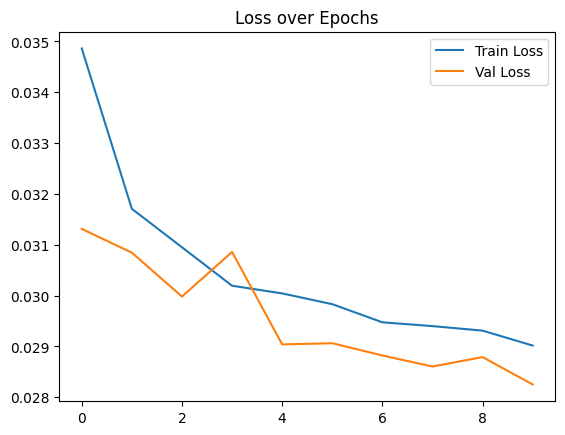

Avg ΔE: 10.8782, Avg SSIM: 0.9411


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


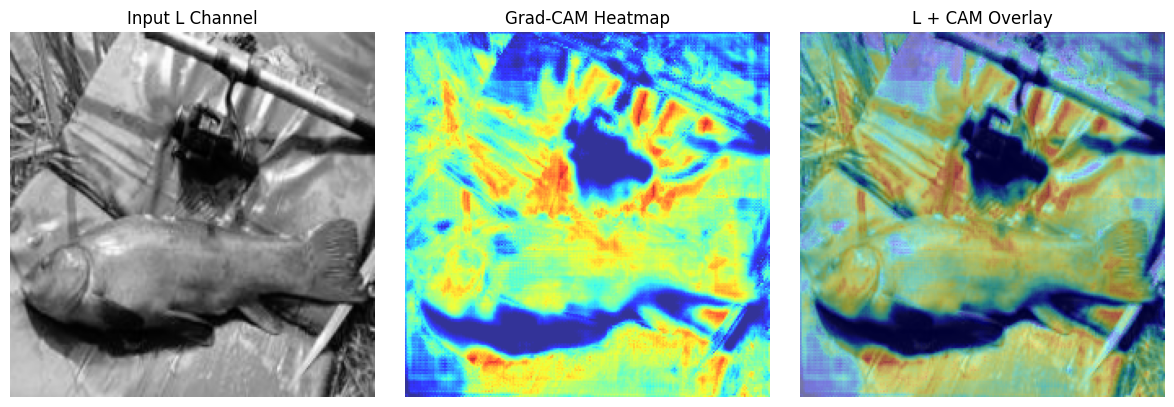

In [ ]:
# ---------- SETUP ----------
import torch
from torch.utils.data import DataLoader

# Initialize model
netC = ColorizationUNet().cuda()

# Initialize Dataset and Dataloaders
train_dataset = ImageFolder(root=train_dir, transform=vgg_transform)
val_dataset = ImageFolder(root=val_dir, transform=vgg_transform)

train_loader = DataLoader(ColorizationDataset(train_dataset), batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(ColorizationDataset(val_dataset), batch_size=16, shuffle=False, num_workers=2)

# ---------- TRAINING CALL ----------
trained_model = train_model(netC, train_loader, val_loader, num_epochs=10, lr=2e-4)

# ---------- EVALUATION ON ONE BATCH ----------
# ---------- EVALUATION WITH GRAD-CAM ----------
trained_model.eval()

for target_L, target_ab, ref_rgb in val_loader:
    target_L, target_ab = target_L.cuda(), target_ab.cuda()
    warped_ab = torch.zeros_like(target_ab).cuda()
    sim_maps = torch.zeros(target_L.size(0), 10, *target_L.shape[2:]).cuda()
    final_input = torch.cat([target_L / 50. - 1.0, warped_ab / 110., sim_maps], dim=1)

    # Regular evaluation
    with torch.no_grad():
        pred_ab = trained_model(final_input)
        evaluate_accuracy(pred_ab, target_L, target_ab)

    # Grad-CAM visualization (take first sample)
    single_input = final_input[:1].requires_grad_(True)
    visualize_gradcam(trained_model, single_input)

    break

In [ ]:
# Save the trained model
torch.save(trained_model.state_dict(), 'colorization_model.pth')
print("Model saved!")

Model saved!


In [ ]:
# Load the trained model (replace the training section with this)
netC = ColorizationUNet().cuda()
netC.load_state_dict(torch.load('colorization_model.pth'))
trained_model = netC
print("Model loaded!")

Model loaded!



=== Example 1/5 ===
Avg ΔE: 7.4768, Avg SSIM: 0.9692


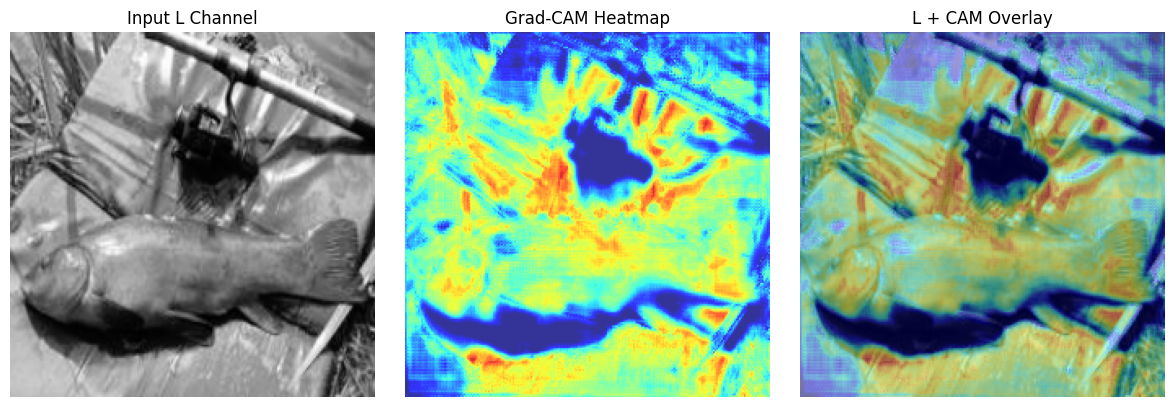


=== Example 2/5 ===
Avg ΔE: 8.6316, Avg SSIM: 0.9734


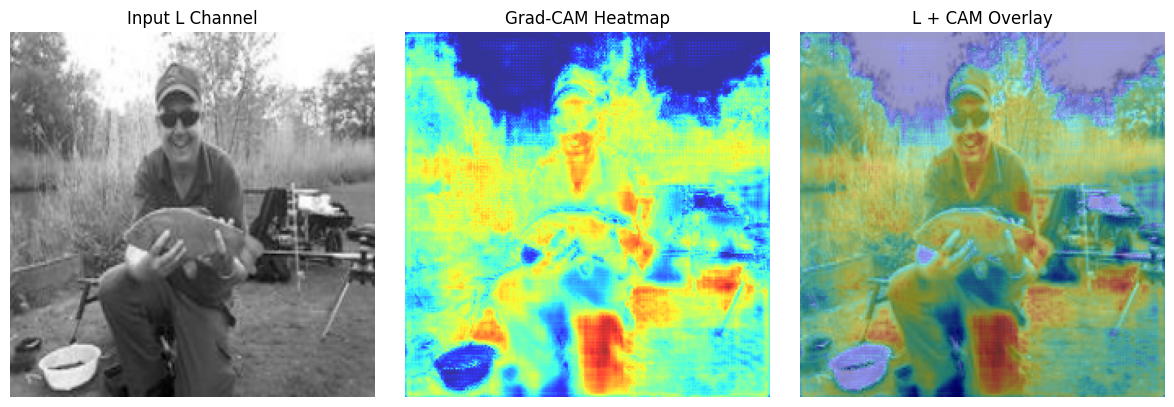


=== Example 3/5 ===
Avg ΔE: 5.1882, Avg SSIM: 0.9807


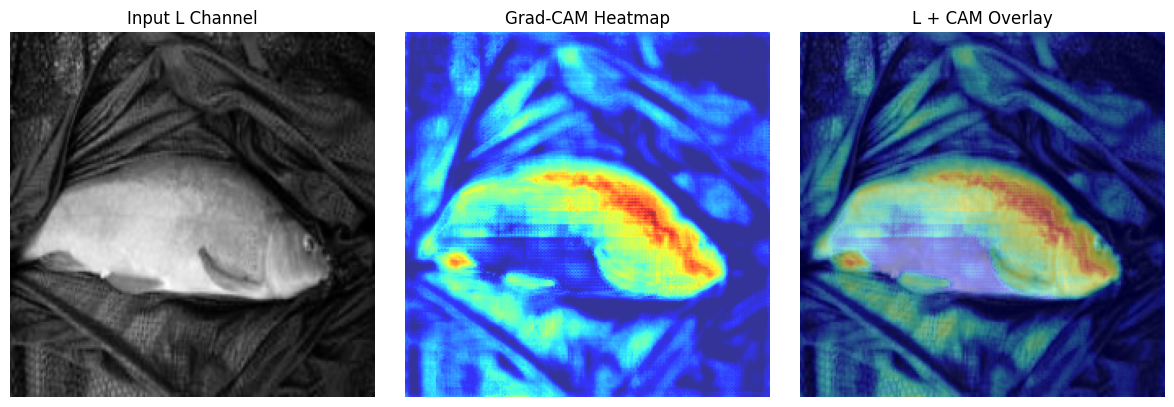


=== Example 4/5 ===
Avg ΔE: 10.4085, Avg SSIM: 0.9481


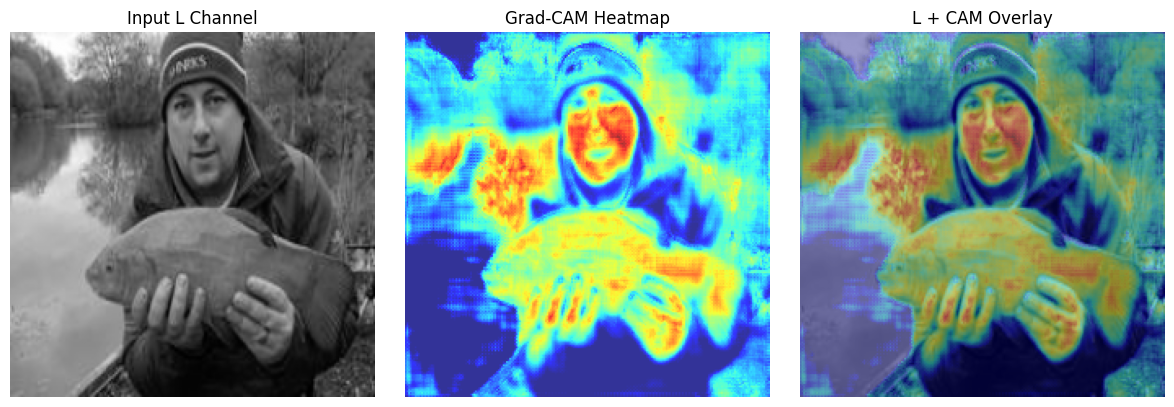


=== Example 5/5 ===
Avg ΔE: 5.0072, Avg SSIM: 0.9844


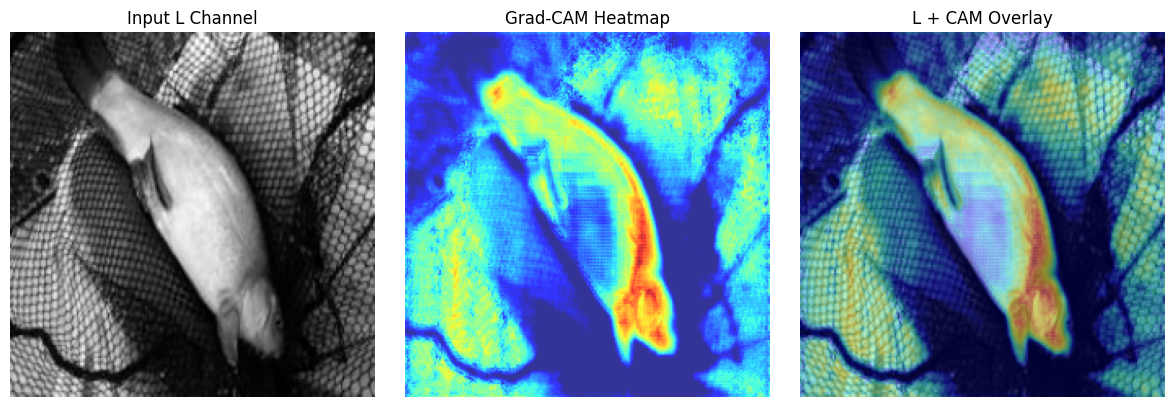


Completed evaluation on 5 examples!


In [ ]:
# ---------- EVALUATION WITH GRAD-CAM (5 EXAMPLES) ----------
trained_model.eval()

sample_count = 0
for target_L, target_ab, ref_rgb in val_loader:
    target_L, target_ab = target_L.cuda(), target_ab.cuda()
    warped_ab = torch.zeros_like(target_ab).cuda()
    sim_maps = torch.zeros(target_L.size(0), 10, *target_L.shape[2:]).cuda()
    final_input = torch.cat([target_L / 50. - 1.0, warped_ab / 110., sim_maps], dim=1)

    # Process each sample in the batch (up to 5 total)
    batch_size = target_L.size(0)
    for i in range(min(batch_size, 5 - sample_count)):
        print(f"\n=== Example {sample_count + 1}/5 ===")

        # Regular evaluation for this sample
        with torch.no_grad():
            single_pred = trained_model(final_input[i:i+1])
            evaluate_accuracy(single_pred, target_L[i:i+1], target_ab[i:i+1])

        # Grad-CAM visualization
        single_input = final_input[i:i+1].requires_grad_(True)
        visualize_gradcam(trained_model, single_input)

        sample_count += 1
        if sample_count >= 5:
            break

    if sample_count >= 5:
        break

print(f"\nCompleted evaluation on {sample_count} examples!")

In [ ]:
pip install lpips scikit-image scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import mean_squared_error
from skimage.color import lab2rgb
import numpy as np
import lpips

# Initialize LPIPS model on GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_fn = lpips.LPIPS(net='alex').to(device)

def evaluate_model_metrics(model, dataloader, max_batches=10):
    # Ensure the model is on the desired device (GPU or CPU)
    device = next(model.parameters()).device # Get device from model parameters
    model.eval()
    lpips_fn.to(device) # Ensure LPIPS is on the same device as the model


    total_psnr = 0
    total_ssim = 0
    total_mse = 0
    total_lpips = 0
    count = 0

    with torch.no_grad():
        for batch_idx, (target_L, target_ab, ref_rgb) in enumerate(dataloader):
            if batch_idx >= max_batches:
                break

            # Move input tensors to the same device as the model
            target_L = target_L.to(device)
            target_ab = target_ab.to(device)
            warped_ab = torch.zeros_like(target_ab).to(device)
            sim_maps = torch.zeros(target_L.size(0), 10, *target_L.shape[2:]).to(device)

            final_input = torch.cat([target_L / 50. - 1.0, warped_ab / 110., sim_maps], dim=1)
            pred_ab = model(final_input)

            for i in range(pred_ab.size(0)):
                L = target_L[i].cpu().numpy() # Move back to CPU for numpy operations
                ab_pred = pred_ab[i].cpu().numpy() * 110.
                ab_true = target_ab[i].cpu().numpy()

                lab_pred = np.concatenate([L, ab_pred], axis=0).transpose(1, 2, 0)
                lab_true = np.concatenate([L, ab_true], axis=0).transpose(1, 2, 0)


                rgb_pred = lab2rgb(lab_pred.astype(np.float32))
                rgb_true = lab2rgb(lab_true.astype(np.float32))

                total_psnr += peak_signal_noise_ratio(rgb_true, rgb_pred, data_range=1.0)
                total_ssim += structural_similarity(rgb_true, rgb_pred, channel_axis=-1, data_range=1.0)
                total_mse += mean_squared_error(rgb_true.flatten(), rgb_pred.flatten())

                # LPIPS requires tensors in [-1, 1] range and [B, C, H, W] format on the correct device
                pred_tensor = torch.tensor(rgb_pred).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1
                true_tensor = torch.tensor(rgb_true).permute(2, 0, 1).unsqueeze(0).float().to(device) * 2 - 1
                lpips_val = lpips_fn(pred_tensor, true_tensor).item()
                total_lpips += lpips_val

                count += 1

    print(f"\nAverage PSNR: {total_psnr / count:.2f}")
    print(f"Average SSIM: {total_ssim / count:.4f}")
    print(f"Average MSE : {total_mse / count:.6f}")
    print(f"Average LPIPS: {total_lpips / count:.4f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
evaluate_model_metrics(trained_model, val_loader, max_batches=10)



Average PSNR: 24.12
Average SSIM: 0.9384
Average MSE : 0.005191
Average LPIPS: 0.1882
